In [1]:
from src.common.logger import get_logger

logger = get_logger(__name__)
import warnings
warnings.filterwarnings("ignore")

from IPython import get_ipython
ip = get_ipython()
ip.magic("reload_ext autoreload")  # these will enable module autoreloading
ip.magic("autoreload 2")

In [2]:
import json
import os
from typing import Dict, Optional

#import mlflow
import pandas as pd
import tensorflow as tf
import yaml
from dvclive.keras import DVCLiveCallback

from src.common.load_data import load_featurized_data
from src.config.const import HISTORY_PARAMS_PATH, HISTORY_PATH, TRAIN_MODEL_PATH
from src.vault_dagshub import DAGSHUB_PASSWORD, DAGSHUB_USERNAME
from src.evaluate import main as eval_main
from src.common.create_model import create_single_shot_model, AutoregressiveModel

2022-11-20 03:57:31.965029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 03:57:32.130465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-20 03:57:32.130485: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-20 03:57:32.164666: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-20 03:57:32.825354: W tensorflow/stream_executor/platform/de

In [3]:
# mlflow settings
os.environ["MLFLOW_TRACKING_USERNAME"] = DAGSHUB_USERNAME
os.environ["MLFLOW_TRACKING_PASSWORD"] = DAGSHUB_PASSWORD
os.environ[
    "MLFLOW_TRACKING_URI"
] = "https://dagshub.com/marcos-mansur/load-forecast.mlflow"

params = yaml.safe_load(open("params.yaml"))
#mlflow.tensorflow.autolog(registered_model_name=f"{params['featurize']['MODEL_TYPE']}")


In [4]:
def compile_and_fit(
    data,
    val_data: pd.DataFrame,
    model,
    epochs: int,
    optimizer: tf.keras.optimizers,
    filepath: str,
    batch_size: int,
    patience: int = 4,
    x: Optional[pd.DataFrame] = None,
    y: Optional[pd.DataFrame] = None,
    
) -> Dict:
    # early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )
    # checkpoint callback
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=filepath, monitor="loss", verbose=0, save_best_only=True, mode="min"
    )

    # compile
    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=optimizer,
        metrics=[
            tf.metrics.MeanAbsoluteError(),
            tf.metrics.MeanAbsolutePercentageError(),
            tf.keras.metrics.RootMeanSquaredError(),
        ],
    )
    # fit data
    history = model.fit(
        data,
        epochs=150,
        verbose=1,
        validation_data=val_data,
        callbacks=[early_stopping],  # DVCLiveCallback()],  # , checkpoint
        batch_size=batch_size,
    )

    return history

In [5]:
def create_model(params):
    
    if params['featurize']['MODEL_TYPE'] == "AUTOREGRESSIVE":
        return AutoregressiveModel(
            units=params['train']['NEURONS'][0], 
            out_steps=params['featurize']['TARGET_PERIOD']
        )

    if params['featurize']['MODEL_TYPE'] == "SINGLE-SHOT":
        return create_single_shot_model(params=params)

In [6]:
for x,y in dataset:
    print(x)
    print(y)
    break

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_405046/518582235.py:1 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_405046/518582235.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'dataset' is not defined

In [7]:
load_dataset_list["train"][1]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_405046/3881969982.py:1 in <module>                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_405046/3881969982.py'                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'load_dataset_list' is not defined

In [9]:
load_dataset_list = load_featurized_data()

# with mlflow.start_run():
#     print("MLFLOW RUN: STARTED!")

    # create model
model = create_model(params=params)
if model:
    print("CREATE MODEL: DONE!")


x = tf.convert_to_tensor(load_dataset_list["train"][0])
y = tf.convert_to_tensor(load_dataset_list["train"][1])

dataset = tf.concat(values=[x,y],axis=-1)
dataset = tf.data.Dataset.from_tensor_slices(dataset)
dataset = dataset.map(
    lambda window: (
        window[:-1],
        window[-params['featurize']['TARGET_PERIOD']:]
        )
)

dataset = dataset.batch(params['featurize']['BATCH_SIZE_PRO']).prefetch(1)

val_data_temp = tf.convert_to_tensor(load_dataset_list["val"][0])
val_x = tf.convert_to_tensor(load_dataset_list["val"][0])
val_y = tf.convert_to_tensor(load_dataset_list["val"][1])
val_concat = tf.concat(values=[val_x,val_y],axis=-1)
val_dataset = tf.data.Dataset.from_tensor_slices(val_concat)

val_data = val_dataset.map(
    lambda window: (
        window[:-1],
        window[-params['featurize']['TARGET_PERIOD']:]
        )
)
val_data = val_data.batch(params['featurize']['BATCH_SIZE_PRO']).prefetch(1)


print("MODEL TRAINING: STARTING!")
history = compile_and_fit(
    data=dataset,
    # x=load_dataset_list["train"][0],
    # y=load_dataset_list["train"][1],
    model=model,
    epochs=params["train"]["EPOCHS"],
    val_data=val_data,
    optimizer=tf.optimizers.Adam(),
    patience=params["train"]["PATIENCE"],
    filepath=params["train"]["MODEL_NAME"],
    batch_size=params["featurize"]["BATCH_SIZE_PRO"],
)
# print("MODEL TRAINING: DONE!")

# with open(HISTORY_PATH, "w") as history_file:
#     json.dump(history.history, history_file)
# with open(HISTORY_PARAMS_PATH, "w") as history_params_file:
#     json.dump(history.params, history_params_file)
# print("TRAIN HISTORY STORED TO DISK")

# # save model to disk
# os.makedirs(TRAIN_MODEL_PATH, exist_ok=True)
# model.save(os.path.join(TRAIN_MODEL_PATH, params["train"]["MODEL_NAME"]))
# print("TRAINED MODEL STORED TO DISK")

#     # mlflow.end_run()
        


CREATE MODEL: DONE!
MODEL TRAINING: STARTING!
Epoch 1/150


11/11 [==============================] - 4s 49ms/step - loss: 1280492032.0000 - mean_absolute_error: 35710.3711 - mean_absolute_percentage_error: 100.0000 - root_mean_squared_error: 35783.9648 - val_loss: 1420995712.0000 - val_mean_absolute_error: 37571.1562 - val_mean_absolute_percentage_error: 99.9986 - val_root_mean_squared_error: 37696.0977
Epoch 2/150
11/11 [==============================] - 0s 8ms/step - loss: 1280489344.0000 - mean_absolute_error: 35710.3359 - mean_absolute_percentage_error: 99.9999 - root_mean_squared_error: 35783.9258 - val_loss: 1420994944.0000 - val_mean_absolute_error: 37571.1406 - val_mean_absolute_percentage_error: 99.9986 - val_root_mean_squared_error: 37696.0820
Epoch 3/150
11/11 [==============================] - 0s 10ms/step - loss: 1280486144.0000 - mean_absolute_error: 35710.2891 - mean_absolute_percentage_error: 99.9997 - root_mean_squared_error: 35783.8828 - val_loss: 1420993408.0000 - va

In [10]:
model.summary()

Model: "autoregressive_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             multiple                  0         
                                                                 
 batch_normalization (BatchN  multiple                 4         
 ormalization)                                                   
                                                                 
 lstm_cell (LSTMCell)        multiple                  32        
                                                                 
 rnn (RNN)                   multiple                  32        
                                                                 
 dense (Dense)               multiple                  3         
                                                                 
Total params: 39
Trainable params: 37
Non-trainable params: 2
__________________________________________________

Forecasting type: AUTOREGRESSIVE... Done!
Forecasting type: AUTOREGRESSIVE... Done!


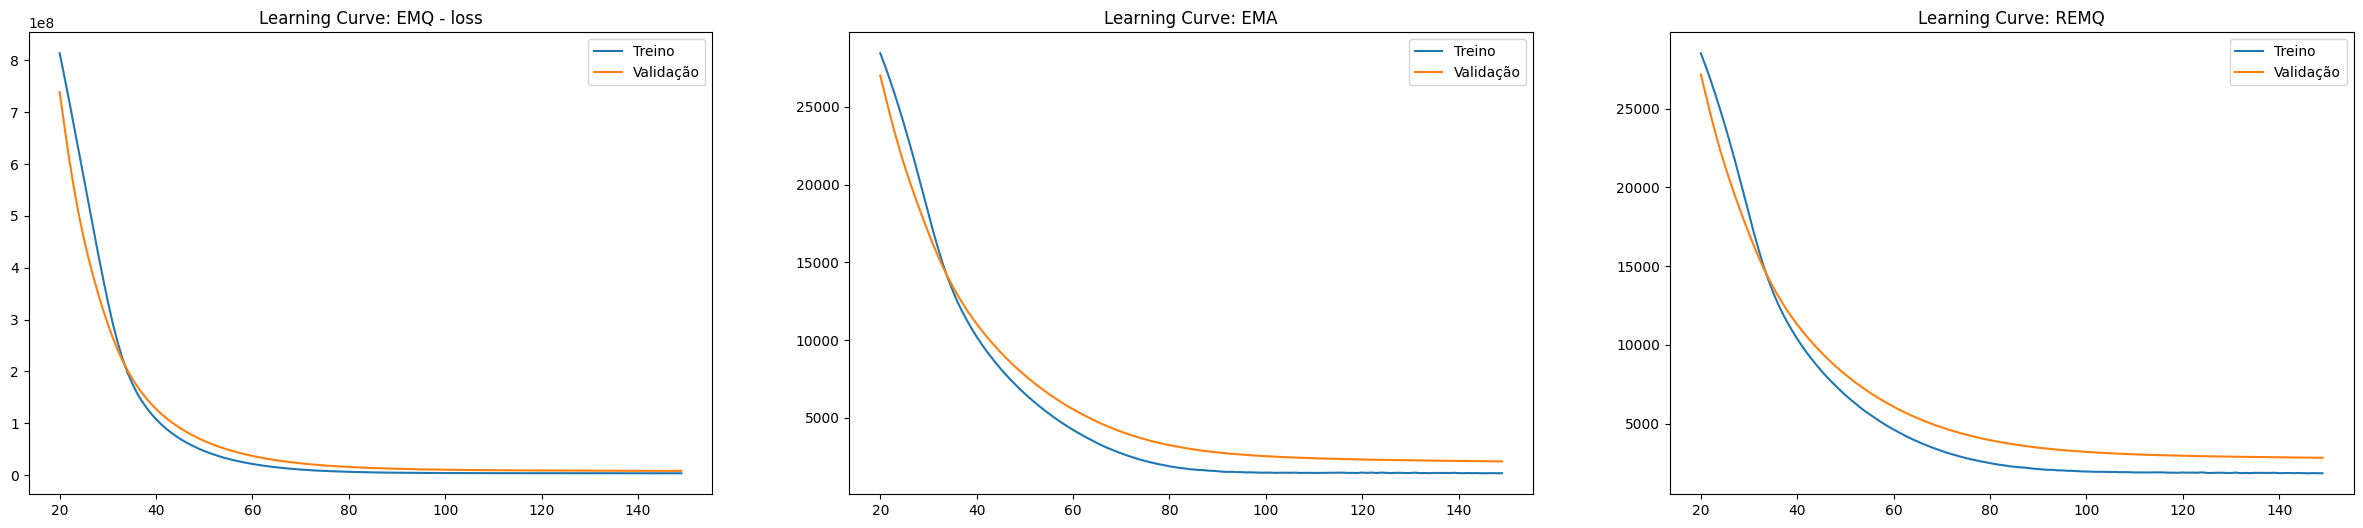

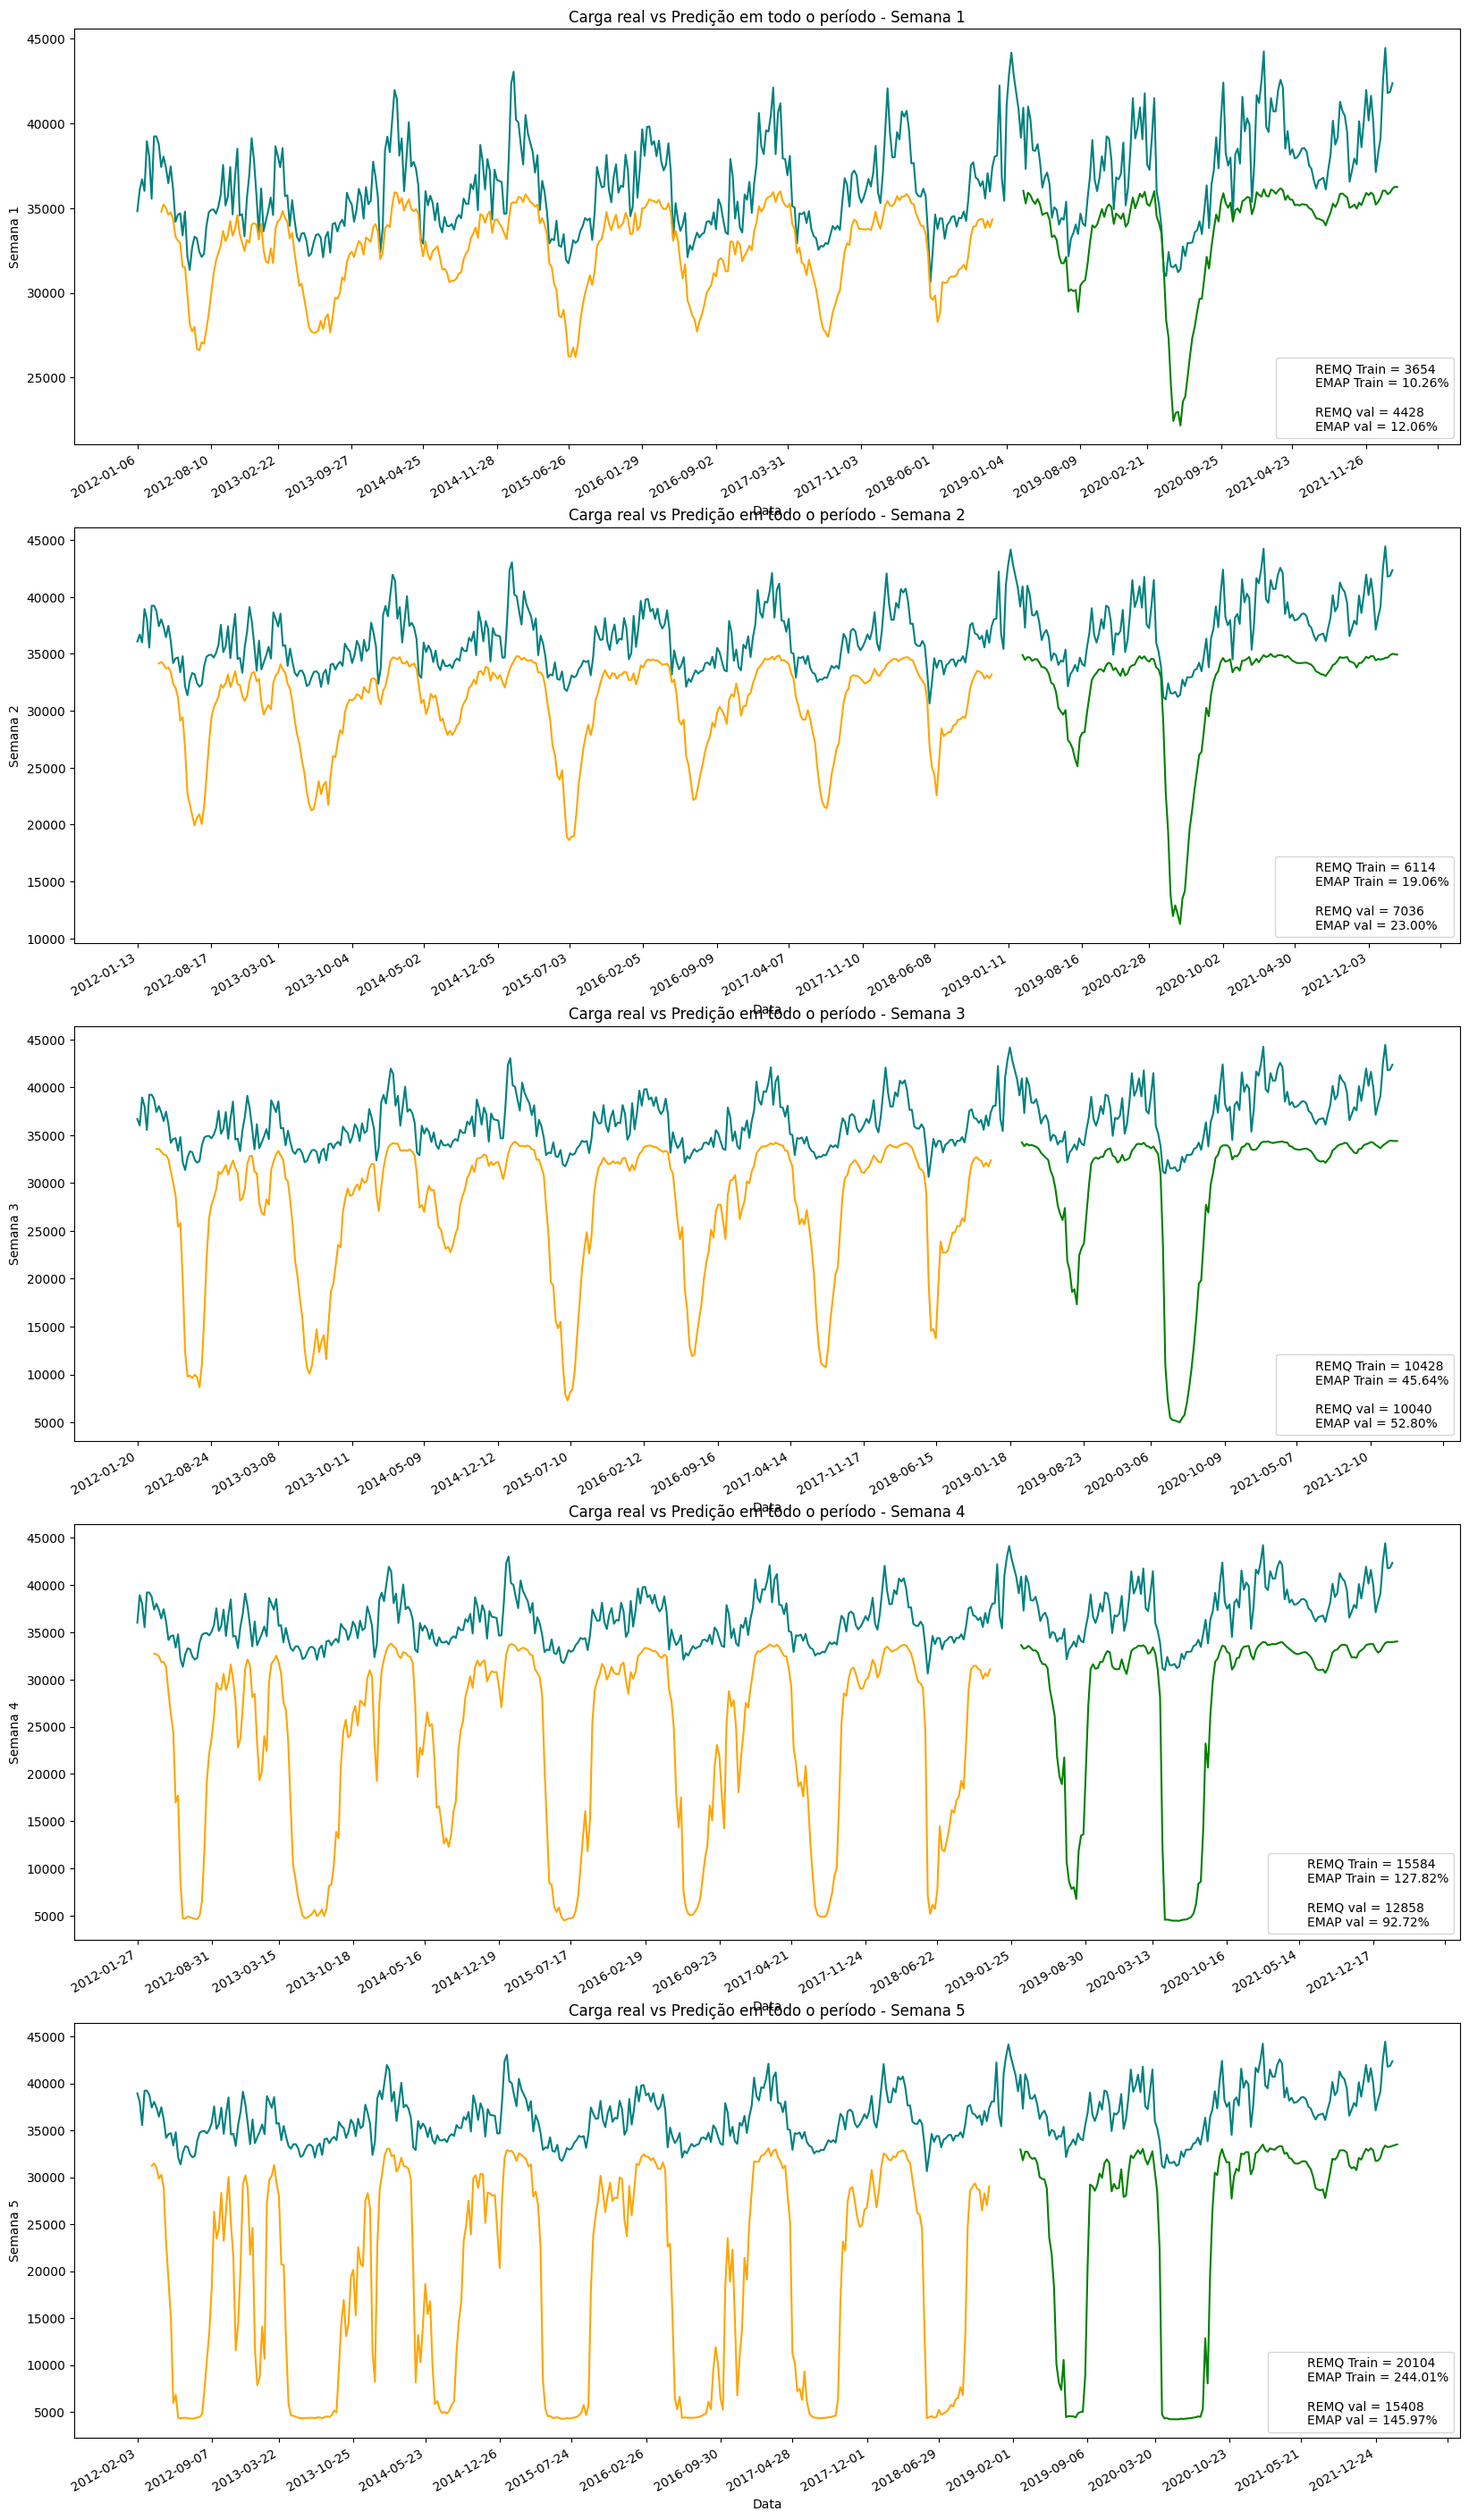

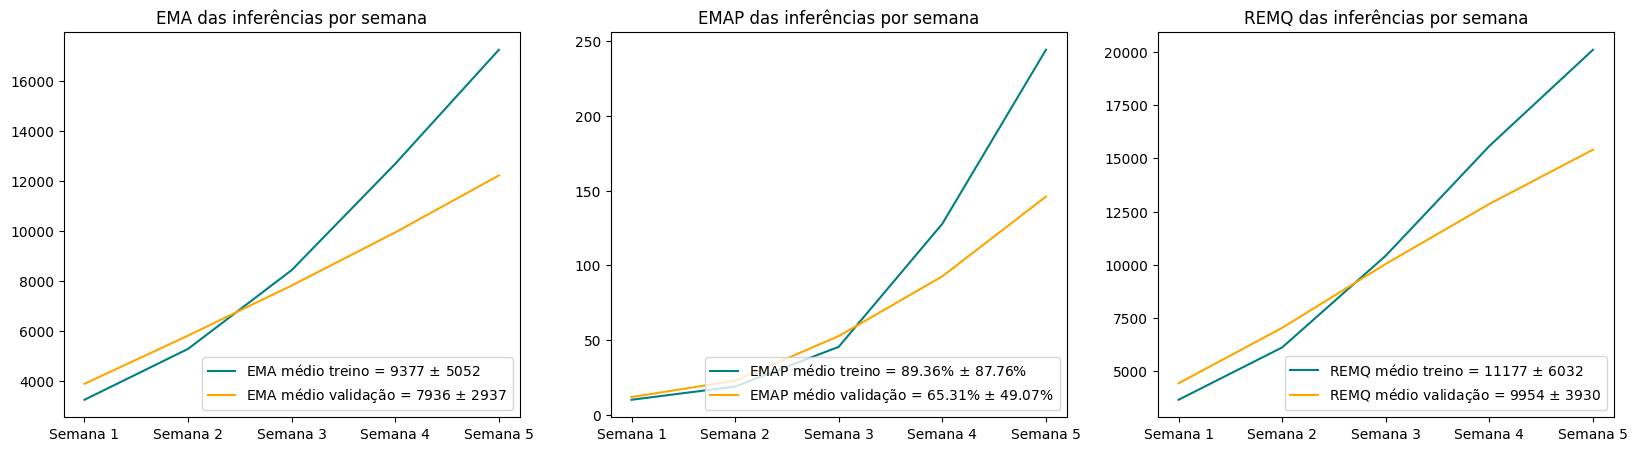

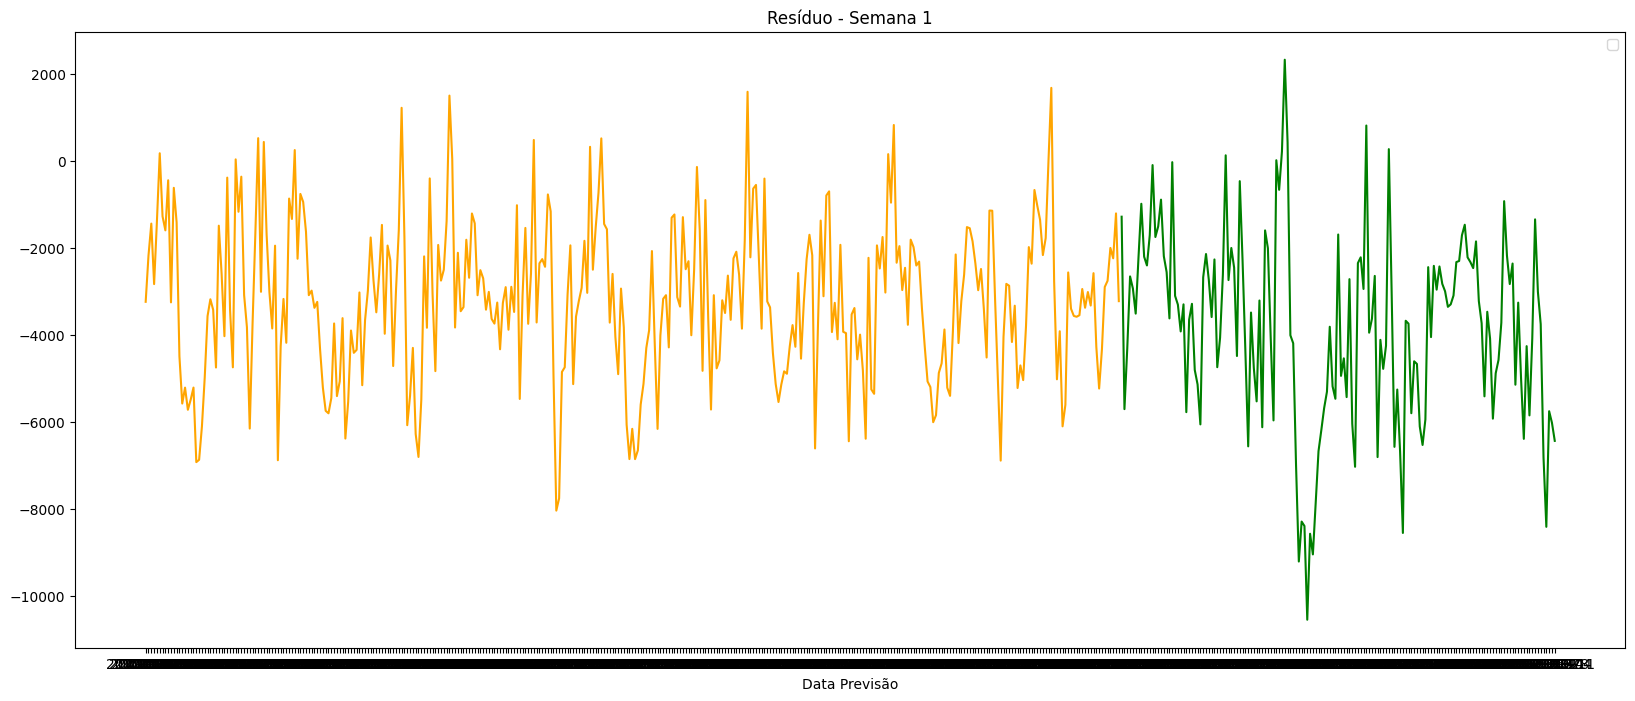

In [11]:
eval_main()